## SME: BJ goods and competitive banks 
Given policy $\tau$, we get real money balance $(z)$ and market interest rate $(i=i_{l}=i_{d})$ by solving
$$
\begin{equation}
\begin{split}
z^{\star} \leftarrow  \frac{1+\tau -\beta}{\beta} &= R(z,i)
\\
i_{l}=i_{d}=i^{\star} \leftarrow \alpha_{0} z &= \int^{\tilde{\rho}}_{\underline{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \xi(i,\rho,z) \text{d}J(\rho)
\end{split}
%\label{eq:k-phi-high-type-case1}
\end{equation}
$$
where
\begin{equation*}
\begin{split}
R(z,i) &:= \alpha_{0}i_{d} + \int^{\tilde{\rho}}_{\underline{\rho}} i [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \text{d}J(\rho)
\\
&+ \int^{\hat{\rho}}_{\tilde{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \bigg[\frac{1}{\rho}\bigg(\frac{z}{\rho}\bigg)^{-\sigma} -1 \bigg] \text{d}J(\rho)
\end{split}
\end{equation*}

* Two equations and two unknowns 

### Calibrated parameters
* $(\sigma_{DM}, \bar{U}_{CM}) = (0.28, 1.9)$
* $\lambda = 0.62$
    * $\alpha_{0} = (1-\lambda)^2$
    * $\alpha_{1} = 2(1-\lambda)\lambda$
    * $\alpha_{2} = \lambda^{2}$
    
        

In [1]:
import bcw_bj as main # KLLN (baseline)
import hlmw as hlmw   # Head, Liu, Menzio and Wright 
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

In [3]:
# Baseline
model = main.baseline_mod(σ_DM=0.28, λ=0.62, Ubar_CM=1.9) 
# HLMW
model_hlmw = hlmw.hlmw_mod(σ_DM=0.28, λ=0.62, Ubar_CM=1.9) 

### Allocation 

$$
        q_{b}\left(\rho, i, z \right)
        =
        \begin{cases}
          \left[\rho \left(1+i\right)\right]^{-1/\sigma}
          &
          \text{if } 0< \rho \leq \tilde{\rho}_{i}
          \\
          \frac{z}{\rho}
          &
          \text{if }\tilde{\rho}_{i} < \rho < \hat{\rho}
          \\
          \rho^{-1/\sigma}
          &
          \text{if } \rho \geq \hat{\rho}
        \end{cases}.
        %\label{eq:Demand q-ss}
 $$

#### Credit + own money: $\rho \in [\underline{\rho}(z), \tilde{\rho}_{i}(z)]$

\begin{equation}
q_{0} = \int^{\tilde{\rho}_{i}(z)}_{\underline{\rho}(z)} [\alpha_{1}+2\alpha_{2}(1-J_{i}(\rho,z)][\rho(1+i)]^{-\frac{1}{\sigma}}\text{d}J_{i}(\rho,z)
\end{equation}

#### Own money constrained: $\rho \in (\tilde{\rho}_{i}(z), \hat{\rho}(z))$

\begin{equation}
q_{1} = \int^{\hat{\rho}(z)}_{\tilde{\rho}_{i}(z)} [\alpha_{1}+2\alpha_{2}(1-J_{i}(\rho,z)]\bigg(\frac{z}{\rho}\bigg)\text{d}J_{i}(\rho,z)
\end{equation}

#### Own money unconstrained: $\rho \in [\hat{\rho}(z), \overline{\rho}(z)]$

\begin{equation}
q_{2} = \int^{\overline{\rho}(z)}_{\hat{\rho}(z)} [\alpha_{1}+2\alpha_{2}(1-J_{i}(\rho,z)]\rho^{-\frac{1}{\sigma}}\text{d}J_{i}(\rho,z)
\end{equation}

Likewise, for HLMW.

In [4]:
def Total_q_func_credit(z, i, τ):
    """KLLN allocation: credit buyers"""
    ρ_grid = model.support_grid_func(z, i, τ)
    
    ρ_tilde = model.ρ_tilde_func(z, i)
    
    ρ_grid_credit = ρ_grid[ρ_grid <= ρ_tilde]
    
    pdf_grid = model.dF_normalization_func(z, i, τ)
        
    em_func = lambda ρ: model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(ρ, i, z) ) 
            
    em = np.array( [em_func(ρ) for ρ in ρ_grid_credit] )
        
    q_expost = np.array( [model.q_demand_func(ρ, i, z) for ρ in ρ_grid_credit] )
        
    integrand_values = em * q_expost * pdf_grid[ρ_grid<=ρ_tilde]
        
    total_q_credit = np.trapz(integrand_values, ρ_grid_credit)
        
    return total_q_credit

In [5]:
def Total_q_func_money_c(z, i, τ):
    """KLLN allocation: money constrained buyers"""
    ρ_grid = model.support_grid_func(z, i, τ)
    
    ρ_tilde = model.ρ_tilde_func(z, i)
    ρ_hat = model.ρ_hat_func(z)
    
    ρ_grid_money = ρ_grid[(ρ_tilde < ρ_grid) & (ρ_grid < ρ_hat)]
    
    pdf_grid_full = model.dF_normalization_func(z, i, τ)
    
    pdf_grid = pdf_grid_full[(ρ_tilde < ρ_grid) & (ρ_grid < ρ_hat)]
        
    em_func = lambda ρ: model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(ρ, i, z) )
    
    em = np.array([em_func(ρ) for ρ in ρ_grid_money])
        
    q_expost = np.array([model.q_demand_func(ρ, i, z) for ρ in ρ_grid_money])
    
    integrand_values = em * q_expost * pdf_grid

    total_q_money_c = np.trapz(integrand_values, ρ_grid_money)
        
    return total_q_money_c


In [6]:
def Total_q_func_money_uc(z, i, τ):
    """KLLN allocation: money unconstrained buyers"""
    ρ_grid = model.support_grid_func(z, i, τ)

    ρ_hat = model.ρ_hat_func(z)
    
    ρ_grid_money_uc = ρ_grid[ρ_hat <= ρ_grid]
    
    pdf_grid_full = model.dF_normalization_func(z, i, τ)
    
    pdf_grid = pdf_grid_full[ρ_hat <= ρ_grid]
        
    em_func = lambda ρ: model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(ρ, i, z) )
    
    em = np.array([em_func(ρ) for ρ in ρ_grid_money_uc])
        
    q_expost = np.array([model.q_demand_func(ρ, i, z) for ρ in ρ_grid_money_uc])
    
    integrand_values = em * q_expost * pdf_grid

    total_q_money_uc = np.trapz(integrand_values, ρ_grid_money_uc)
        
    return total_q_money_uc


### DM net trading surplus

#### Credit + own money:  $\rho \in [\underline{\rho}(z), \tilde{\rho}_{i}(z)]$

\begin{equation}
\int^{\tilde{\rho}_{i}(z)}_{\underline{\rho}(z)} [\alpha_{1}+2\alpha_{2}(1-J_{i}(\rho,z)]u[q_{b}(\rho,i,z)] - c[q_{b}(\rho,i,z)]\text{d}J_{i}(\rho,z)
\end{equation}

#### Own money constrained: $\rho \in (\tilde{\rho}_{i}(z), \hat{\rho}(z))$
$$
 \int^{\hat{\rho}(z)}_{\tilde{\rho}_{i}(z)} [\alpha_{1}+2\alpha_{2}(1-J_{i}(\rho,z)]u[q_{b}(\rho,i,z)] - c[q_{b}(\rho,i,z)]\text{d}J_{i}(\rho,z)
$$

#### Own money unconstrained: $\rho \in [\hat{\rho}(z), \overline{\rho}(z)]$
$$
 \int^{\overline{\rho}(z)}_{\hat{\rho}(z)} [\alpha_{1}+2\alpha_{2}(1-J_{i}(\rho,z)]u[q_{b}(\rho, i, z)] - c[q_{b}(\rho, i, z)]\text{d}J_{i}(\rho,z),
$$

where
$$
        q_{b}\left(\rho, i, z \right)
        =
        \begin{cases}
          \left[\rho \left(1+i\right)\right]^{-1/\sigma}
          &
          \text{if } 0< \rho \leq \tilde{\rho}_{i}
          \\
          \frac{z}{\rho}
          &
          \text{if }\tilde{\rho}_{i} < \rho < \hat{\rho}
          \\
          \rho^{-1/\sigma}
          &
          \text{if } \rho \geq \hat{\rho}
        \end{cases}.
        %\label{eq:Demand q-ss}
 $$
 
 Likewise, for HLMW

In [7]:
def surplus_credit_func(z, i, τ):
    """KLLN DM trading surplus: credit buyers"""
    ρ_grid = model.support_grid_func(z, i, τ)
    
    ρ_tilde = model.ρ_tilde_func(z, i)
    
    ρ_grid_credit = ρ_grid[ρ_grid <= ρ_tilde]
    
    pdf_grid = model.dF_normalization_func(z, i, τ)
        
    em_func = lambda ρ: model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(ρ, i, z) ) 
            
    em = np.array( [em_func(ρ) for ρ in ρ_grid_credit] )
        
    net_q_expost = np.array( [model.u_DM(model.q_demand_func(ρ, i, z)) -\
                          model.cost_DM(model.q_demand_func(ρ, i, z)) for ρ in ρ_grid_credit] )
        
    integrand_values = em * net_q_expost * pdf_grid[ρ_grid<=ρ_tilde]
        
    surplus = np.trapz(integrand_values, ρ_grid_credit)
        
    return surplus

In [8]:
def surplus_money_c_func(z, i, τ):
    """KLLN DM trading surplus: money constrained buyers"""
    ρ_grid = model.support_grid_func(z, i, τ)
    
    ρ_tilde = model.ρ_tilde_func(z, i)
    ρ_hat = model.ρ_hat_func(z)
    
    ρ_grid_money = ρ_grid[(ρ_tilde < ρ_grid) & (ρ_grid < ρ_hat)]
    
    pdf_grid_full = model.dF_normalization_func(z, i, τ)
    
    pdf_grid = pdf_grid_full[(ρ_tilde < ρ_grid) & (ρ_grid < ρ_hat)]
        
    em_func = lambda ρ: model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(ρ, i, z) )
    
    em = np.array([em_func(ρ) for ρ in ρ_grid_money])
        
    net_q_expost = np.array( [model.u_DM(model.q_demand_func(ρ, i, z)) -\
                          model.cost_DM(model.q_demand_func(ρ, i, z)) for ρ in ρ_grid_money] )
    
    integrand_values = em * net_q_expost * pdf_grid

    surplus_money_c = np.trapz(integrand_values, ρ_grid_money)
        
    return surplus_money_c


In [9]:
def surplus_money_uc_func(z, i, τ):
    """KLLN DM trading surplus: money unconstrained buyers"""
    ρ_grid = model.support_grid_func(z, i, τ)

    ρ_hat = model.ρ_hat_func(z)
    
    ρ_grid_money_uc = ρ_grid[ρ_hat <= ρ_grid]
    
    pdf_grid_full = model.dF_normalization_func(z, i, τ)
    
    pdf_grid = pdf_grid_full[ρ_hat <= ρ_grid]
        
    em_func = lambda ρ: model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(ρ, i, z) )
    
    em = np.array([em_func(ρ) for ρ in ρ_grid_money_uc])
        
    net_q_expost = np.array( [model.u_DM(model.q_demand_func(ρ, i, z)) -\
                          model.cost_DM(model.q_demand_func(ρ, i, z)) for ρ in ρ_grid_money_uc] )
    
    integrand_values = em * net_q_expost * pdf_grid

    surplus_money_uc = np.trapz(integrand_values, ρ_grid_money_uc)
        
    return surplus_money_uc


### HLMW: allocation

In [10]:
def Total_q_c_func_hlmw(z, τ):
    """HLMW allcoation: money constrained buyers"""
    ρ_grid = model_hlmw.support_grid_func(z, τ)
    
    ρ_hat = model_hlmw.ρ_hat_func(z)    
    
    ρ_grid_money = ρ_grid[ρ_grid < ρ_hat]
    
    pdf_grid_full = model_hlmw.dF_normalization_func(z, τ)
    
    pdf_grid = pdf_grid_full[ρ_grid < ρ_hat]

    em_func = lambda ρ: model_hlmw.α_1 + 2.0*model_hlmw.α_2*( 1.0 - model_hlmw.F_func(ρ, z) ) 
            
    em = np.array( [em_func(ρ) for ρ in ρ_grid_money] )
        
    q_expost = np.array( [model_hlmw.q_demand_func(ρ, z) for ρ in ρ_grid_money] )
        
    integrand_values = em * q_expost * pdf_grid
        
    total_q_c = np.trapz(integrand_values, ρ_grid_money)
        
    return total_q_c

In [11]:
def Total_q_uc_func_hlmw(z, τ):
    """HLMW allcoation: money unconstrained buyers"""
    ρ_grid = model_hlmw.support_grid_func(z, τ)
    
    ρ_hat = model_hlmw.ρ_hat_func(z)    
    
    ρ_grid_money_uc = ρ_grid[ρ_hat<=ρ_grid]
    
    pdf_grid_full = model_hlmw.dF_normalization_func(z, τ)
    
    pdf_grid = pdf_grid_full[ρ_hat<=ρ_grid]

    em_func = lambda ρ: model_hlmw.α_1 + 2.0*model_hlmw.α_2*( 1.0 - model_hlmw.F_func(ρ, z) ) 
            
    em = np.array( [em_func(ρ) for ρ in ρ_grid_money_uc] )
        
    q_expost = np.array( [model_hlmw.q_demand_func(ρ, z) for ρ in ρ_grid_money_uc] )
        
    integrand_values = em * q_expost * pdf_grid
        
    total_q_uc = np.trapz(integrand_values, ρ_grid_money_uc)
        
    return total_q_uc

### HLMW: DM net trading surplus

In [12]:
def surplus_money_c_func_hlmw(z, τ):
    """HLMW DM surplus: money constrained buyers"""
    ρ_grid = model_hlmw.support_grid_func(z, τ)
    
    ρ_hat = model_hlmw.ρ_hat_func(z)    
    
    ρ_grid_money = ρ_grid[ρ_grid < ρ_hat]
    
    pdf_grid_full = model_hlmw.dF_normalization_func(z, τ)
    
    pdf_grid = pdf_grid_full[ρ_grid < ρ_hat]

    em_func = lambda ρ: model_hlmw.α_1 + 2.0*model_hlmw.α_2*( 1.0 - model_hlmw.F_func(ρ, z) ) 
            
    em = np.array( [em_func(ρ) for ρ in ρ_grid_money] )
        
    net_q_expost = np.array( [model_hlmw.u_DM(model_hlmw.q_demand_func(ρ, z)) -\
                          model_hlmw.cost_DM(model_hlmw.q_demand_func(ρ, z)) for ρ in ρ_grid_money] )
        
    integrand_values = em * net_q_expost * pdf_grid
        
    surplus_c = np.trapz(integrand_values, ρ_grid_money)
        
    return surplus_c

In [13]:
def surplus_money_uc_func_hlmw(z, τ):
    """HLMW DM surplus: money unconstrained buyers"""
    ρ_grid = model_hlmw.support_grid_func(z, τ)
    
    ρ_hat = model_hlmw.ρ_hat_func(z)    
    
    ρ_grid_money_uc = ρ_grid[ρ_hat<=ρ_grid]
    
    pdf_grid_full = model_hlmw.dF_normalization_func(z, τ)
    
    pdf_grid = pdf_grid_full[ρ_hat<=ρ_grid]

    em_func = lambda ρ: model_hlmw.α_1 + 2.0*model_hlmw.α_2*( 1.0 - model_hlmw.F_func(ρ, z) ) 
            
    em = np.array( [em_func(ρ) for ρ in ρ_grid_money_uc] )
        
    net_q_expost = np.array( [model_hlmw.u_DM(model_hlmw.q_demand_func(ρ, z)) -\
                          model_hlmw.cost_DM(model_hlmw.q_demand_func(ρ, z)) for ρ in ρ_grid_money_uc] )
        
    integrand_values = em * net_q_expost * pdf_grid
        
    surplus_uc = np.trapz(integrand_values, ρ_grid_money_uc)
        
    return surplus_uc

### Experiment: solve SME for $\tau \in [\beta-1, 0.1]$

#### Baseline

In [14]:
# Baseline
result = model.SME_stat(0.4, 1e-3) #guess for z and i

Elapsed time of solving SME: 8073.089538812637 seconds


In [15]:
z_grid=result['allocation_grid']['zstar']
i_grid=result['allocation_grid']['istar']

In [16]:
# credit + money allocation
q_credit = [Total_q_func_credit(z,i,τ) for (z,i,τ) in zip(z_grid, i_grid, model.τ_grid)]

In [17]:
# own money constrained allocation
q_money_c  = [Total_q_func_money_c(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid, model.τ_grid)]

In [18]:
# own money unconstrained allocation
q_money_uc  = [Total_q_func_money_uc(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid, model.τ_grid)]

#### HLMW

In [19]:
# HLWM
result_hlmw = model_hlmw.SME_stat()

Elapsed time of solving SME: 4234.172754764557 seconds


In [20]:
z_grid_hlmw=result_hlmw['allocation_grid']['zstar']

In [21]:
# HLMW: own money constrained allocation
q_money_c_hlmw = [Total_q_c_func_hlmw(z,τ) for (z,τ) in zip(z_grid_hlmw, model.τ_grid)]                  

In [22]:
# HLMW: own money unconstrained allocation
q_money_uc_hlmw = [Total_q_uc_func_hlmw(z,τ) for (z,τ) in zip(z_grid_hlmw, model.τ_grid)]                  

#### DM net trading surplus (baseline)

In [23]:
# credit + money
surplus_credit = [surplus_credit_func(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid, model.τ_grid)]   

In [24]:
# own money constrained
surplus_m_c = [surplus_money_c_func(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid, model.τ_grid)]           

In [25]:
# own money unconstrained
surplus_m_uc = [surplus_money_uc_func(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid, model.τ_grid)]                

In [26]:
total = np.array([model.DM_utility(z,i,τ) for (z,i,τ) in zip(z_grid, i_grid, model.τ_grid)])

#### DM net trading surplus (HLMW)

In [27]:
# own money constrained
surplus_c_hlmw = [surplus_money_c_func_hlmw(z,τ) for (z,τ) in zip(z_grid_hlmw, model.τ_grid)]

In [28]:
# own money unconstrained
surplus_uc_hlmw = [surplus_money_uc_func_hlmw(z,τ) for (z,τ) in zip(z_grid_hlmw, model.τ_grid)]

In [29]:
total_hlmw = np.array([model_hlmw.DM_utility(z,τ) for (z,τ) in zip(z_grid_hlmw,  model.τ_grid)])

In [30]:
i_grid = model.i_policy(model.τ_grid)

In [31]:
# String label for x-axes (below)
x_string = r"Nominal interest rate $i$ ($\%$)"

### Visualization

#### Plot (aggregate) DM net trading surplus for baseline and HLMW

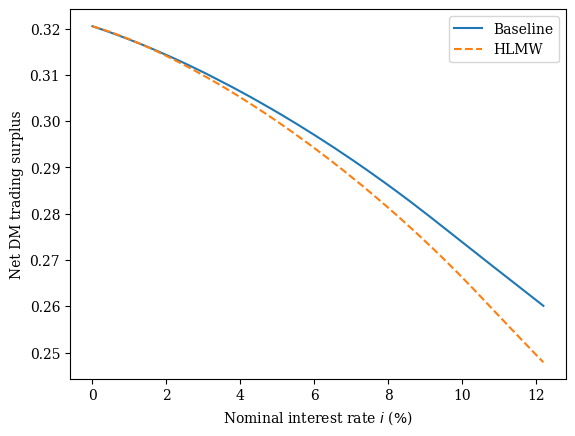

In [32]:
plt.plot(i_grid*100, total, '-', label='Baseline')
plt.plot(i_grid*100, total_hlmw, '--', label='HLMW')
plt.ylabel("Net DM trading surplus")
plt.xlabel(x_string)
plt.legend()
plt.show()


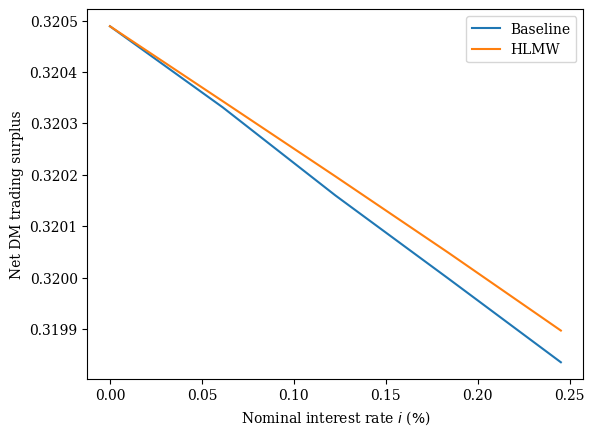

In [33]:
# Zoom-in
plt.plot(i_grid[0:5]*100, total[0:5], label='Baseline')
plt.plot(i_grid[0:5]*100, total_hlmw[0:5], label='HLMW')
plt.ylabel("Net DM trading surplus")
plt.xlabel(x_string)
plt.legend()
plt.show()


#### Plot the difference in (aggregate) DM net trading surplus (baseline vs. HLMW)

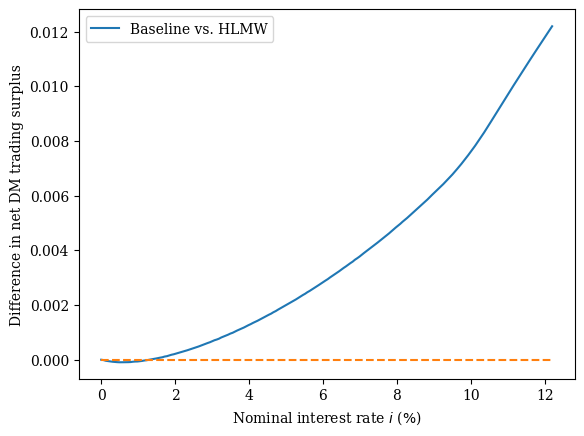

In [34]:
plt.plot(i_grid*100, total - total_hlmw, label='Baseline vs. HLMW')
plt.plot(i_grid*100, np.zeros(total.size), '--')
plt.ylabel("Difference in net DM trading surplus")
plt.xlabel(x_string)
plt.legend()
plt.show()


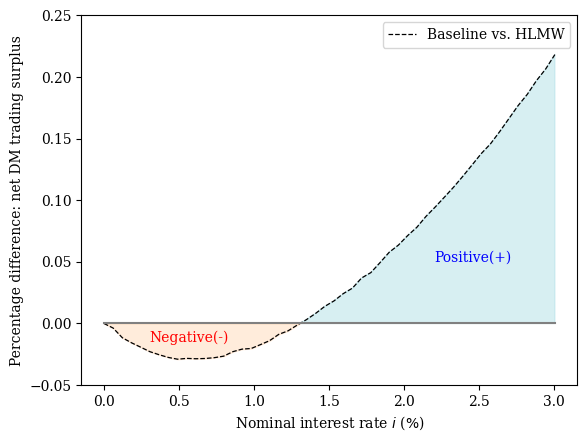

In [35]:
### ZOOM-IN

τ_cut = 50

plt.plot(i_grid[0:τ_cut]*100, 
         100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut],       label='Baseline vs. HLMW',color='black', linestyle='--',linewidth=0.9)
plt.plot(i_grid[0:τ_cut]*100, np.zeros(total[0:τ_cut].size), color="gray")
plt.ylabel("Percentage difference: net DM trading surplus")
plt.fill_between(i_grid[0:τ_cut]*100, 100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut],where=(100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut] <= 0), color='peachpuff', alpha=0.5, interpolate=True)
plt.fill_between(i_grid[0:τ_cut]*100, 100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut],where=(100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut] >= 0), color='#B0E0E6', alpha=0.5, interpolate=True)
plt.ylim(-0.05,0.25)
plt.text(0.3, -0.015, 'Negative(-)',size=10,color='red')
plt.text(2.2, 0.05, 'Positive(+)',size=10,color='blue')
plt.xlabel(x_string)
plt.legend()
plt.savefig("Money (non-credit) constrained buyers.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


### Decompose: different payment types of buyers

#### Plot the (level) DM net trading surplus (baseline vs. HLMW): for credit-buyers
* Credit buyers: use both own money and loans 
* In HLMW, no credit buyers

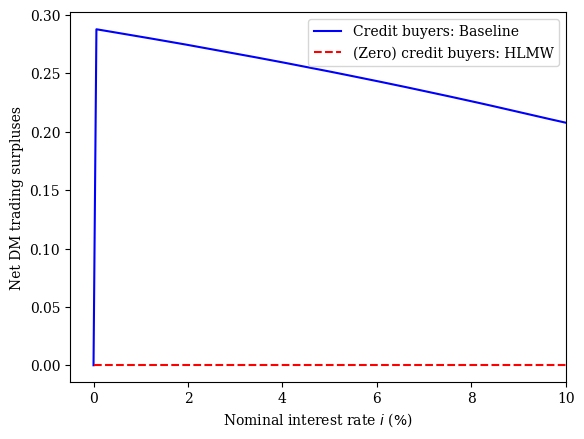

In [36]:
plt.plot(i_grid*100, np.array(surplus_credit), 
            '-', 
            label='Credit buyers: Baseline',color="blue")
plt.plot(i_grid*100, np.zeros(np.array(surplus_credit).size), 
            '--', 
            label='(Zero) credit buyers: HLMW',color="red")
plt.ylabel("Net DM trading surpluses")
plt.xlabel(x_string)
plt.xlim(-0.5,10)
plt.legend()
plt.savefig("surplus-credit-buyers.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

#### Plot the (level) DM net trading surplus (baseline vs. HLMW): constrained money-buyers
* Only money constrained buyers (baseline)
* Only money constrained buyers (HLMW)

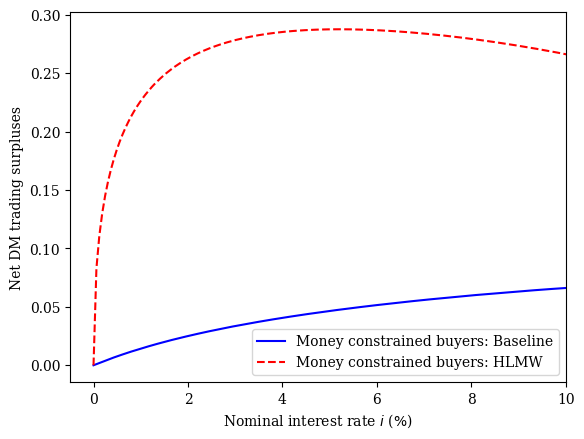

In [37]:
plt.plot(i_grid*100, np.array(surplus_m_c),
         '-', 
         label='Money constrained buyers: Baseline',color="blue")
plt.plot(i_grid*100, np.array(surplus_c_hlmw),
         '--', 
         label='Money constrained buyers: HLMW',color="red")
plt.ylabel("Net DM trading surpluses")
plt.xlabel(x_string)
plt.legend()
plt.xlim(-0.5,10)
plt.savefig("surplus-money-constrained-buyers.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

#### Plot the (level) DM net trading surplus (baseline vs. HLMW): unconstrained money-buyers
* Own money unconstrained buyers (baseline)
* Own money unconstrained buyers (HLMW)

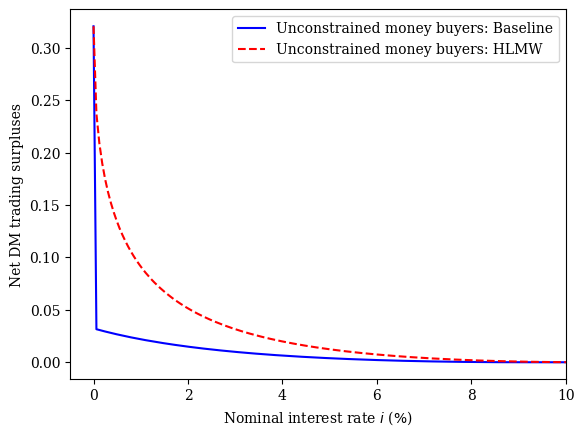

In [38]:
plt.plot(i_grid*100, np.array(surplus_m_uc) ,
         '-', 
                                label='Unconstrained money buyers: Baseline',color="blue")
plt.plot(i_grid*100, np.array(surplus_uc_hlmw),
         '--', 
                                label='Unconstrained money buyers: HLMW',color="red")
plt.ylabel("Net DM trading surpluses")
plt.xlabel(x_string)
plt.legend()
plt.xlim(-0.5,10)
plt.savefig("surplus-money-unconstrained-buyers.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

## Pricing cutoffs and inflation

In [39]:
# Our baseline economy
# lower bound on prices - money unconstrained buyers
# upper bound on prices - money constrained buyers
ρ_hat_baseline = [model.ρ_hat_func(z) for z in z_grid]

# lower bound - money constrained buyers
# upper bound - credit buyers
ρ_tilde_baseline = [model.ρ_tilde_func(z,i) for (z,i) in zip(z_grid, i_grid)]

# HMLW economy
# lower bound on prices - money unconstrained buyers
# upper bound on prices - money constrained buyers
ρ_hat_hlmw = [model_hlmw.ρ_hat_func(z) for z in z_grid_hlmw]

In [40]:
# Same as i_grid above, just repetition for the heck of it!
if_grid = model.i_policy(model.τ_grid)

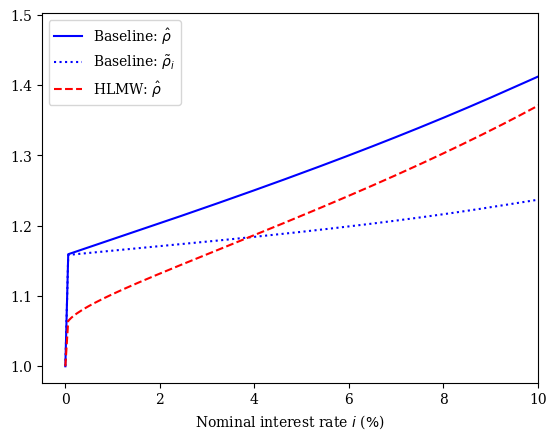

In [47]:
plt.plot(if_grid*100, ρ_hat_baseline, 'b-', label='Baseline: $\hat{ρ}$')
plt.plot(if_grid*100, ρ_tilde_baseline, 'b:', label=r'Baseline: $\tilde{ρ}_{i}$')
plt.plot(if_grid*100, ρ_hat_hlmw, '--', color="red", label='HLMW: $\hat{ρ}$')
plt.xlabel(x_string)
plt.legend()
plt.xlim(-0.5,10)
plt.savefig("cutoffs.png", dpi=600, bbox_inches='tight', pad_inches=0.05)
plt.show()

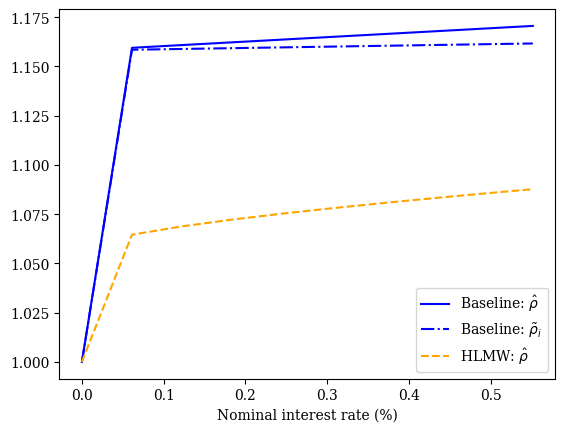

In [48]:
plt.plot(if_grid[:10]*100, ρ_hat_baseline[:10], 'b-', label=r'Baseline: $\hat{ρ}$')
plt.plot(if_grid[:10]*100, ρ_tilde_baseline[:10], 'b-.', label=r'Baseline: $\tilde{ρ}_{i}$')
plt.plot(if_grid[:10]*100, ρ_hat_hlmw[:10], '--', color="orange", label=r'HLMW: $\hat{ρ}$')
plt.xlabel('Nominal interest rate (%)')
plt.legend()
plt.savefig("cutoffs_zoom_in.png", dpi=600)
plt.show()

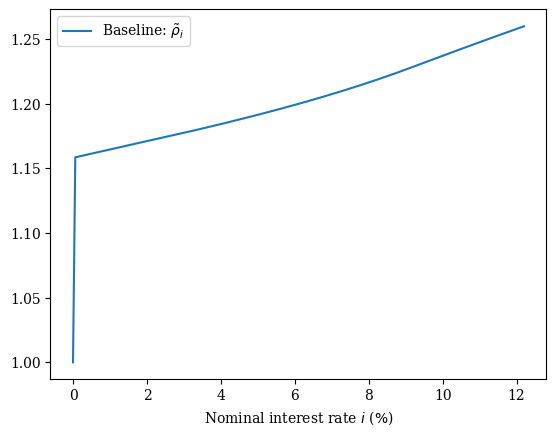

In [49]:
plt.plot(if_grid*100, ρ_tilde_baseline, label=r'Baseline: $\tilde{ρ}_{i}$')
plt.xlabel(x_string)
plt.legend()
plt.savefig("cutoffs_credit_baseline.png", dpi=600)
plt.show()

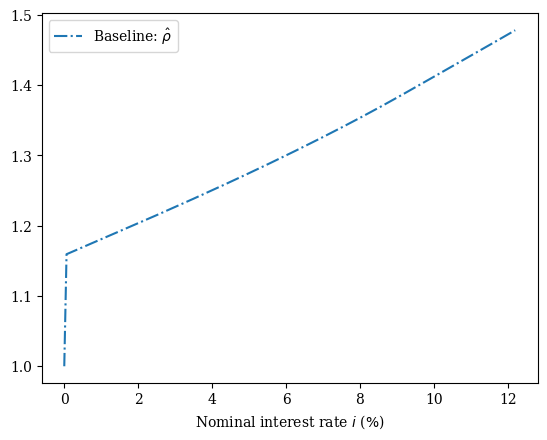

In [50]:
plt.plot(if_grid*100, ρ_hat_baseline, '-.', label=r'Baseline: $\hat{ρ}$')
plt.xlabel(x_string)
plt.legend()
plt.savefig("cutoffs_money_baseline.png", dpi=600)
plt.show()

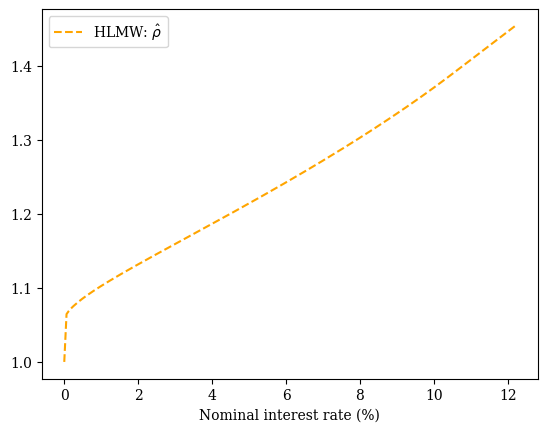

In [51]:
plt.plot(if_grid*100, ρ_hat_hlmw, '--', color="orange", label=r'HLMW: $\hat{ρ}$')
plt.xlabel('Nominal interest rate (%)')
plt.legend()
plt.savefig("cutoffs_money_hlmw.png", dpi=600)
plt.show()